# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 2. Khởi tạo tập dữ liệu

Tập dữ liệu được lưu trữ tại: https://drive.google.com/file/d/1FAq4KGiH92ZJ8Pu4Yiy3qa46t-ismfeB/view?usp=sharing

Các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. 


Thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

# 3. Tiền xử lý dữ liệu

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [ ]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'dataset'
imagePaths = list(paths.list_images(dataset))

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [ ]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
for i in imagePaths[-4000:] + imagePaths[:4000]:  
    label = i.split(os.path.sep)[-2]

    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)

    # Chèn các dữ liệu ảnh vào list data
    data.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data, dtype='uint8')
labels = np.array(labels)

In [ ]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn) 

In [ ]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [ ]:
# Chia tập dữ liệu thành 3 tập là train/validation/test 
train_X, test_X, train_Y, test_Y =  train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y =  train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

In [ ]:
train_X.shape

(4000, 224, 224, 3)

In [ ]:
train_Y.shape

(4000, 2)

In [ ]:
test_X.shape

(3200, 224, 224, 3)

In [ ]:
test_Y.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [ ]:
aug = ImageDataGenerator(rotation_range=20, # xoay hình trong khoảng 0-20 độ
                         zoom_range=0.15, # phóng to ảnh
                         width_shift_range=0.2, # dịch chuyển ảnh theo chiều rộng
                         height_shift_range=0.2, # dịch chuyển ảnh theo chiều cao
                         shear_range=0.15, # cắt ảnh
                         horizontal_flip=True, # lật ảnh trên trục hoành
                         vertical_flip = True, # lật ảnh trên trục tung
                         fill_mode="nearest")

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [ ]:
baseModel = EfficientNetB0(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [ ]:
headModel = baseModel.output 
headModel = AveragePooling2D()(headModel) 
headModel = Flatten(name="flatten")(headModel) 
headModel = Dense(128, activation="relu")(headModel) 
headModel = Dropout(0.5)(headModel) 
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet 

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = Adam(learning_rate = learning_rate, decay = learning_rate / Epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.AUC()])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

Epoch 1/10
100/100 [==============================] - 86s 826ms/step - loss: 0.1258 - auc: 0.9837 - val_loss: 0.0207 - val_auc: 0.9987
Epoch 2/10
100/100 [==============================] - 82s 816ms/step - loss: 0.0634 - auc: 0.9942 - val_loss: 0.0356 - val_auc: 0.9949
Epoch 3/10
100/100 [==============================] - 82s 822ms/step - loss: 0.0542 - auc: 0.9942 - val_loss: 0.0420 - val_auc: 0.9958
Epoch 4/10
100/100 [==============================] - 82s 819ms/step - loss: 0.0697 - auc: 0.9917 - val_loss: 0.0165 - val_auc: 0.9987
Epoch 5/10
100/100 [==============================] - 82s 816ms/step - loss: 0.0444 - auc: 0.9953 - val_loss: 0.0244 - val_auc: 0.9987
Epoch 6/10
100/100 [==============================] - 82s 817ms/step - loss: 0.0444 - auc: 0.9951 - val_loss: 0.0336 - val_auc: 0.9961
Epoch 7/10
100/100 [==============================] - 82s 822ms/step - loss: 0.0402 - auc: 0.9961 - val_loss: 0.0225 - val_auc: 0.9987
Epoch 8/10
100/100 [==============================] - 8

In [ ]:
# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet.model')

INFO:tensorflow:Assets written to: efficientnet.model\assets


INFO:tensorflow:Assets written to: efficientnet.model\assets


- In ra lịch sử huấn luyện của mô hình

In [ ]:
model = load_model('efficientnet.model')

In [ ]:
H.history

{'loss': [0.12575940787792206,
  0.06339560449123383,
  0.05415860563516617,
  0.06971968710422516,
  0.0443609282374382,
  0.04436508193612099,
  0.040179021656513214,
  0.023760559037327766,
  0.04226148501038551,
  0.036364950239658356],
 'auc': [0.9837366938591003,
  0.994231104850769,
  0.9941569566726685,
  0.9917095899581909,
  0.9953277111053467,
  0.9951364994049072,
  0.9960803985595703,
  0.9980767965316772,
  0.9951863884925842,
  0.9968974590301514],
 'val_loss': [0.020741071552038193,
  0.03555165231227875,
  0.04196682944893837,
  0.01646573096513748,
  0.02441263385117054,
  0.03356551751494408,
  0.022452857345342636,
  0.04273604229092598,
  0.029371779412031174,
  0.03236031159758568],
 'val_auc': [0.9987000226974487,
  0.9948922395706177,
  0.9958281517028809,
  0.9986828565597534,
  0.9986671805381775,
  0.9961117506027222,
  0.9986811876296997,
  0.9948452711105347,
  0.9974250197410583,
  0.9960811734199524]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

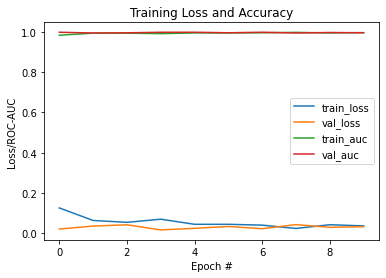

In [ ]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC
N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [ ]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn.

In [ ]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    
    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)
    
    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)
            
            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)
               
    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)
                
    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [ ]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [ ]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224

        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue
        
choose = np.array(choose)

In [ ]:
test_X_align.shape

(3200, 224, 224, 3)

In [ ]:
test_X_align[choose, :, :, :].shape

(1690, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [ ]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [ ]:
predict = model.predict(test_X_align[choose])
predict = np.argmax(predict, axis = 1)
roc_auc_score(np.argmax(test_Y[choose],axis = 1), predict)

53/53 [==============================] - 28s 523ms/step


0.9634586850107464

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [ ]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

1/1 [==============================] - 0s 47ms/step


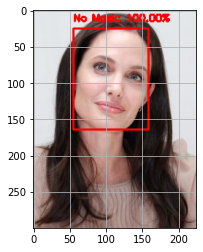

In [ ]:
img = cv2.imread("image/angelina.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 18ms/step


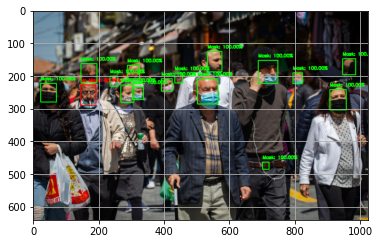

In [ ]:
img = cv2.imread("image/people.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step


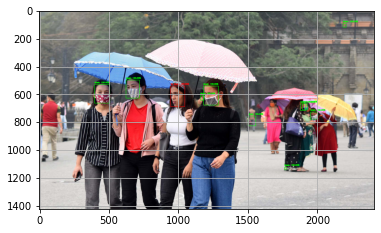

In [ ]:
img = cv2.imread("image/woman.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step


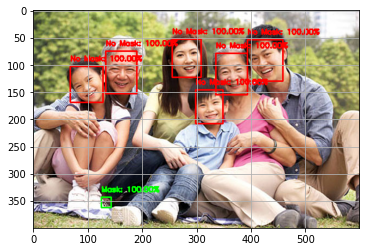

In [ ]:
img = cv2.imread("image/family.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [ ]:
from imutils.video import VideoStream
import imutils

In [ ]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step


# 6. Cải thiện mô hình

- Phần này sẽ đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình. Tức là chỉ số **ROC-AUC >= 0.992**.

In [ ]:
dataset = 'dataset'
imagePaths = list(paths.list_images(dataset))
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
labels = []

# Sử dụng 12000 ảnh tương ứng với đường dẫn imagePaths

for i in imagePaths[-6000:] + imagePaths[:6000]:
   
    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)
    
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data, dtype='uint8')
labels = np.array(labels)
# Sử dụng LabelBinarizer để mã hóa mảng labels
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)
# Chia tập sữ liệu train/val/test
train_X, test_X, train_Y, test_Y =  train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y =  train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

from tensorflow.keras.applications import EfficientNetV2B1
#Khởi tạo base model là EfficientNetV2B1, bổ sung thêm các lớp Dense với hàm kích hoạt relu
base_model2 = EfficientNetV2B1(include_top=False,
                       weights='imagenet',
                       input_tensor = Input(shape = (224, 224, 3)))
headModel2 = base_model2.output
headModel2 = AveragePooling2D()(headModel2)
headModel2 = Flatten(name = 'Flatten')(headModel2)
headModel2 = Dense(512, activation = 'relu')(headModel2)
headModel2 = Dense(128, activation = 'relu')(headModel2)
headModel2 = Dense(64, activation = 'relu')(headModel2)
headModel2 = Dropout(rate = 0.5)(headModel2)
headModel2 = Dense(2, activation = 'softmax')(headModel2)
model2 = Model(inputs = base_model2.input, outputs = headModel2)
# đóng băng các layer của mô hình EfficientNetV2B1
for layer2 in base_model2.layers:
    layer2.trainable = False
#Biên dịch mô hình với learning_rate = 0.001, decay = 0.0001
model2.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate = 0.001, decay = 0.0001),
              metrics=[tf.keras.metrics.AUC()])
# tiến hành tăng cường dữ liệu
aug = ImageDataGenerator(rotation_range=20, # xoay hình trong khoảng 0-20 độ
                          zoom_range=0.2, # phóng to ảnh
                          width_shift_range=0.2, # dịch chuyển ảnh theo chiều rộng
                          height_shift_range=0.2, # dịch chuyển ảnh theo chiều cao
                          shear_range=0.15, # cắt ảnh
                          horizontal_flip=True, # lật ảnh trên trục hoành
                          vertical_flip = True, # lật ảnh trên trục tung
                          fill_mode = 'nearest')
#Khớp mô hình với 12 epochs và batch_size=32, 
H2 = model2.fit(
    aug.flow(train_X, train_Y, batch_size=32, shuffle=True, seed=42 ),
    steps_per_epoch = len(train_X)//32,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//32,
    epochs = 12)

Epoch 1/12
187/187 [==============================] - 123s 629ms/step - loss: 0.1178 - auc_1: 0.9886 - val_loss: 0.0187 - val_auc_1: 0.9990
Epoch 2/12
187/187 [==============================] - 115s 616ms/step - loss: 0.0620 - auc_1: 0.9941 - val_loss: 0.0149 - val_auc_1: 0.9999
Epoch 3/12
187/187 [==============================] - 115s 617ms/step - loss: 0.0549 - auc_1: 0.9947 - val_loss: 0.0124 - val_auc_1: 0.9999
Epoch 4/12
187/187 [==============================] - 116s 620ms/step - loss: 0.0534 - auc_1: 0.9956 - val_loss: 0.0134 - val_auc_1: 0.9991
Epoch 5/12
187/187 [==============================] - 117s 627ms/step - loss: 0.0435 - auc_1: 0.9973 - val_loss: 0.0241 - val_auc_1: 0.9981
Epoch 6/12
187/187 [==============================] - 115s 617ms/step - loss: 0.0407 - auc_1: 0.9967 - val_loss: 0.0078 - val_auc_1: 1.0000
Epoch 7/12
187/187 [==============================] - 116s 619ms/step - loss: 0.0360 - auc_1: 0.9972 - val_loss: 0.0090 - val_auc_1: 0.9991
Epoch 8/12
187/187 [

In [ ]:
# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'EfficientNetV2B1.model'
model2.save('EfficientNetV2B1.model')

INFO:tensorflow:Assets written to: EfficientNetV2B1.model\assets


INFO:tensorflow:Assets written to: EfficientNetV2B1.model\assets


In [ ]:
from sklearn.metrics import roc_auc_score
pred_2 = model2.predict(test_X)
y_pred2 = np.argmax(pred_2, axis = 1)
ROC_AUC2 = roc_auc_score(np.argmax(test_Y, axis = 1), y_pred2)
ROC_AUC2

150/150 [==============================] - 73s 482ms/step


0.9972916666666666

In [ ]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model2.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

1/1 [==============================] - 0s 40ms/step


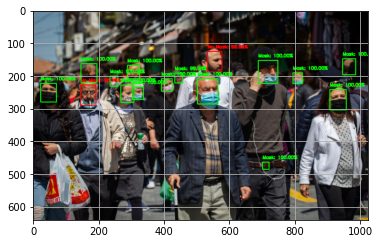

In [ ]:
img = cv2.imread("image/people.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step


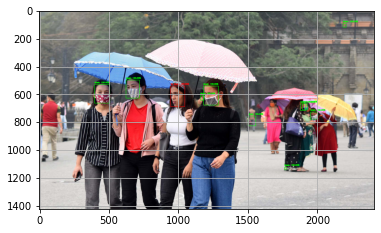

In [ ]:
img = cv2.imread("image/woman.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 38ms/step


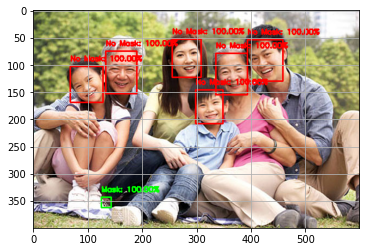

In [ ]:
img = cv2.imread("image/family.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model2.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

1/1 [==============================] - 0s 40ms/step
